In [1]:
import math
import os
import pickle

import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
np.random.seed(1234)

LOAD_DATA = True

DATA_PATH = '../data/train/images/'
LAND_PATH = '../data/train/landmarks.csv'
NOISY_PATH = '../data/train/noisy_stats.csv'

In [2]:
def angle_variation(ps):
    dps = np.diff(ps, axis=0)
    angles = []
    for i in range(len(dps) - 1):
        e1, e2 = dps[i], dps[i+1]
        x = np.clip(e1.dot(e2)/(np.linalg.norm(e1) * np.linalg.norm(e2) + 0.00001), -1, 1)
        angle = math.acos(x)*180/math.pi
        angles.append(angle)

    return np.mean(angles)

In [3]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [4]:
def make_landmarks(row):
    landmark = row
    land_mark_len = landmark.shape[0]
    landmark = landmark.reshape(int(land_mark_len/2), 2)
    return landmark

In [5]:
IMAGE_PATHS = np.array([os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH)])
LANDMARKS = pd.read_csv(LAND_PATH, sep='\t').set_index('file_name')

In [6]:
if LOAD_DATA:
    stats = pd.read_csv(NOISY_PATH, index_col=0)
else:
    stats = []
    for image in tqdm(IMAGE_PATHS):
        img_file = image.split('/')[-1]
        img_landmark = LANDMARKS.loc[img_file].values.reshape(971, 2)
        stat1 = angle_variation(img_landmark[:64,:])
        stat2 = angle_variation(img_landmark[64:128,:])
        stats.append((img_file, stat1, stat2))

    stats = np.array(stats)
    stats = pd.DataFrame({'file': stats[:,0], 
                          'stat1': stats[:, 1].astype(float), 
                          'stat2': stats[:, 2].astype(float)})
    
    stats.to_csv(NOISY_PATH)

In [7]:
stats.head(5)

,file,stat1,stat2
0,f031708eafdc530d5554b187c8dc0acf.jpg,17.779778,18.122500
1,5217fccf0d7757651de0f03253c6ecc0.jpg,22.991173,55.930300
2,ae7855d024cf31abe4f5dc4a4d7e91c2.jpg,16.523520,21.971194
3,72f5f4fab2c4c87013b5c062f4035318.jpg,7.101899,7.880390
4,a88ef7e7bf62bf60fae0496a4cd0ce70.jpg,88.435335,89.957146


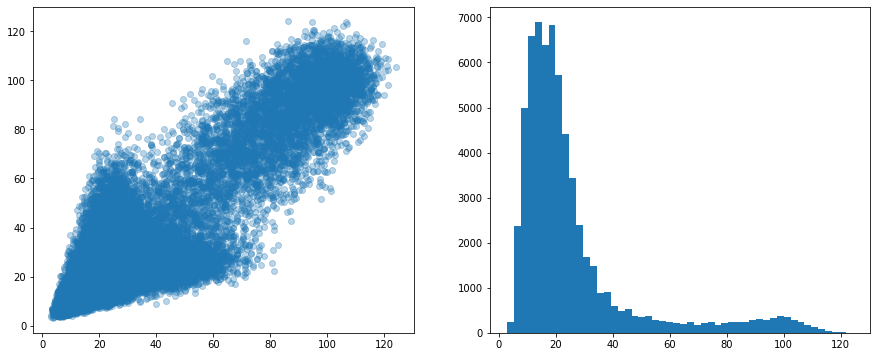

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].scatter(stats['stat1'].values, stats['stat2'].values, alpha=0.3)
axes[1].hist(stats['stat1'].values, bins=50)
plt.show()

In [9]:
from sklearn.cluster import KMeans

In [10]:
kmeans = KMeans(n_clusters=2)
label = kmeans.fit_predict(stats[['stat1', 'stat2']])

In [11]:
stats['label'] = label
class_0 = stats[stats['label'] == 0]
class_1 = stats[stats['label'] == 1]

In [12]:
class_1.head(5)

,file,stat1,stat2,label
4,a88ef7e7bf62bf60fae0496a4cd0ce70.jpg,88.435335,89.957146,1
21,bd5d9199fddbc0d736ca950a3d00cfb2.jpg,102.934397,94.124329,1
24,e15211f4cf7e8b2dbd6d8ff7ce10d5d4.jpg,88.160522,112.685610,1
39,71d70e2ee522c9e7e74804432bfda883.jpg,93.991568,59.597106,1
49,c4b8e0898f40158f561cbde7a6c248d6.jpg,99.548049,97.091786,1


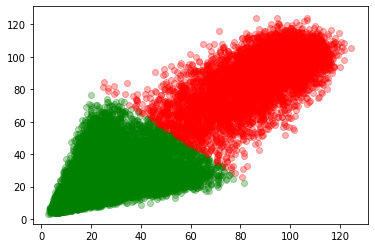

In [13]:
plt.plot(figsize=(15,6))

plt.scatter(class_0['stat1'].values, class_0['stat2'].values, alpha=0.3, color = 'green')
plt.scatter(class_1['stat1'].values, class_1['stat2'].values, alpha=0.3, color = 'red')

plt.show()

In [14]:
ROW_NUM, COL_NUM = 5, 2

In [15]:
random_idxs_normal = np.random.choice(class_0.index, size=ROW_NUM * COL_NUM, replace=False)
random_idxs_noisy = np.random.choice(class_1.index, size=ROW_NUM * COL_NUM, replace=False)

In [16]:
def plot_result(df, index_list):
    plt.figure(figsize=(21, COL_NUM * ROW_NUM))
    for i in range(0, ROW_NUM * COL_NUM):
        ind = index_list[i]
        file_name = df['file'].loc[ind]
        image = cv2.imread(DATA_PATH + file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        landmark = make_landmarks(LANDMARKS.loc[file_name].values)
        image = draw_landmarks(image, landmark)

        plt.subplot(COL_NUM, ROW_NUM, i + 1)
        plt.imshow(image)
        plt.title(file_name)

    plt.tight_layout()
    plt.show()

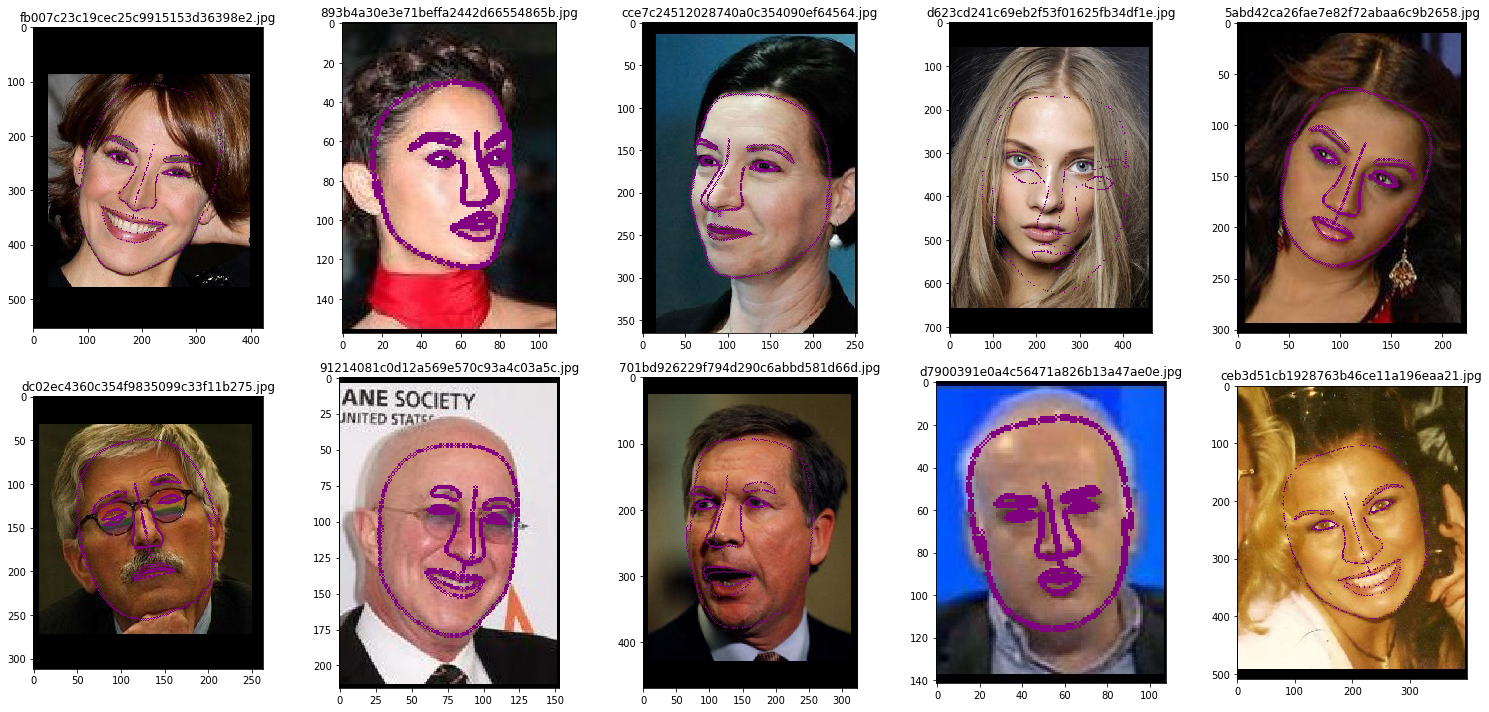

In [17]:
plot_result(class_0, random_idxs_normal)

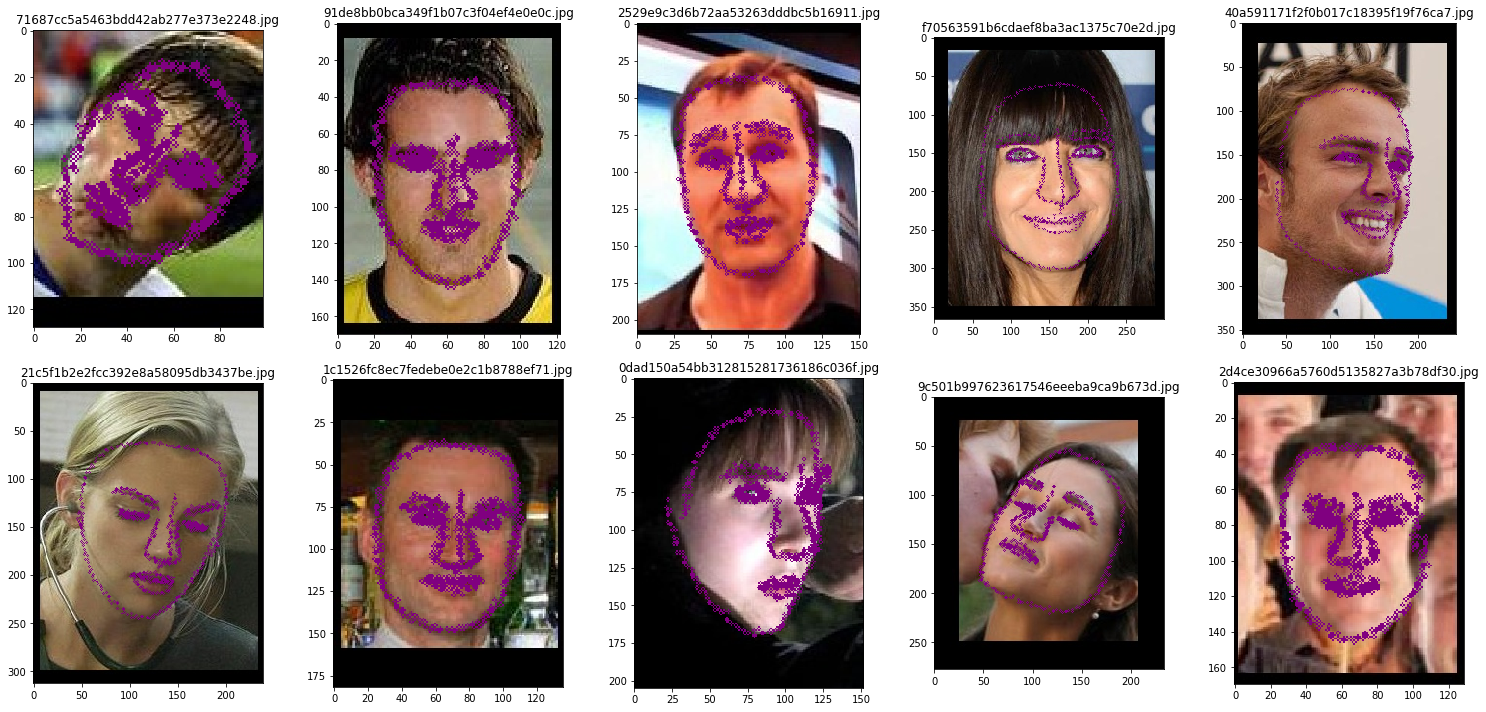

In [18]:
plot_result(class_1, random_idxs_noisy)

In [19]:
noisy_file = class_1['file'].values

In [20]:
with open("../data/train/noisy.txt", "wb") as fp:
    pickle.dump(noisy_file, fp)